In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [198]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# Remove ID from data
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:, 1:]))

In [199]:
## Normalise the numerical data to zero mean. Want all features to contribute equally. Also replace missing values with mean (now zero).
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing values to 0
all_features = all_features.fillna(0)

In [200]:
# Do one hot encoding to replace discrete string features to numbers.
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = all_features.astype('float32')


n_train = train_data.shape[0]
train_features = torch.from_numpy(all_features[:n_train].values)
test_features = torch.from_numpy(all_features[n_train:].values)
train_labels = torch.from_numpy(train_data.SalePrice.values).reshape((-1, 1))
train_features.requires_grad_(True)
test_features.requires_grad_(True)
# train_labels.requires_grad_(True)


tensor([[-0.8735,  0.4581,  0.1843,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.5009,  0.5197,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673,  0.2011,  0.4643,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-0.8735,  3.8850,  1.2466,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6553, -0.3130,  0.0346,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673,  0.2011, -0.0686,  ...,  1.0000,  0.0000,  0.0000]],
       requires_grad=True)

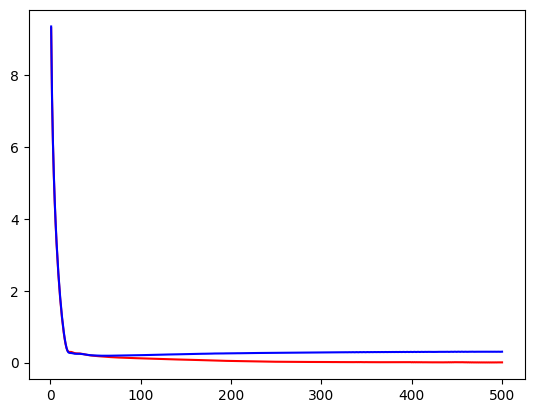

fold 0, train rmse: 0.004361, valid rmse: 0.302095


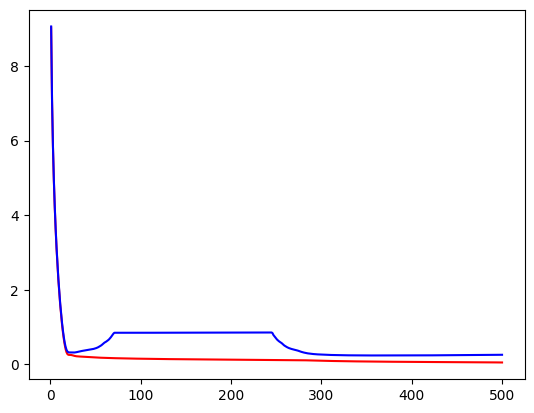

fold 1, train rmse: 0.048992, valid rmse: 0.255467


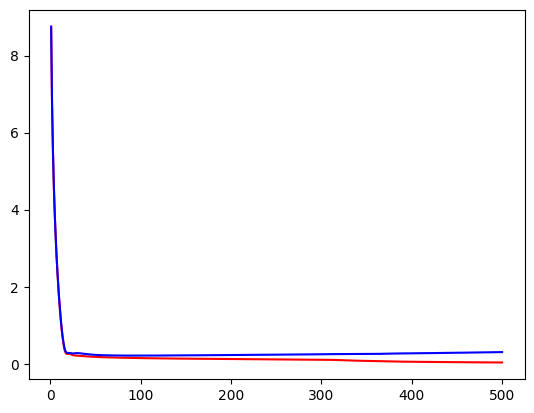

fold 2, train rmse: 0.032323, valid rmse: 0.301939


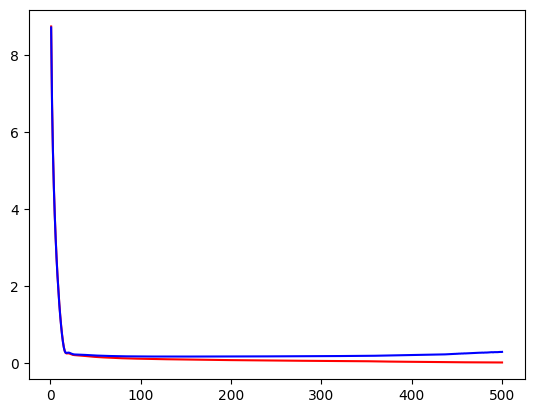

fold 3, train rmse: 0.021609, valid rmse: 0.296722


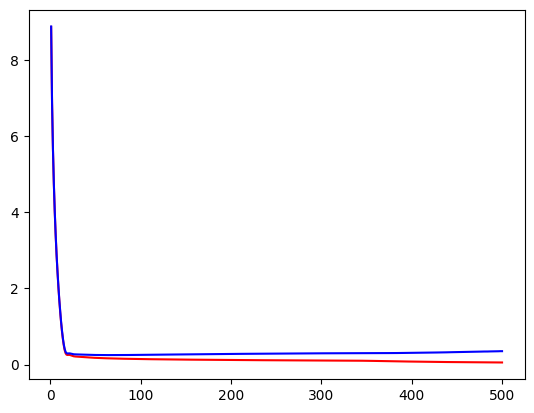

fold 4, train rmse: 0.056411, valid rmse: 0.353277
5-fold validation: avg train rmse: 0.032739, avg valid rmse: 0.301900


In [234]:

class LinearNetwork(nn.Module):
    def __init__(self, lr, weight_decay):
        super(LinearNetwork, self).__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.net = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
        self.l2loss = nn.MSELoss()
        self.optim = torch.optim.Adam(self.net.parameters(), lr=self.lr, weight_decay=self.weight_decay)

    def forward(self, x):
        x = self.net(x)
        return x
    
    def loss(self, y, y_hat):
        return (y - y_hat) ** 2
    
    def rmseloss(self, features, labels):
        clipped_preds = torch.clamp(self.net(features), 1, float('inf'))
        rmse = torch.sqrt(2 * self.loss(clipped_preds.log(), labels.log()).mean())
        return rmse.item()
    
    def get_batches(self, batch_size, features, labels):
        num_batches = len(features) // batch_size
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            batch_features = features[start:end]
            batch_labels = labels[start:end]
            yield batch_features.float(), batch_labels.float()

        if num_batches * batch_size < len(features):
            # There are some leftover data points.
            start = num_batches * batch_size
            end = len(features)
            batch_features = features[start:end]
            batch_labels = labels[start:end]
            yield batch_features.float(), batch_labels.float()

    def train(self, train_features, train_labels, test_features, test_labels, num_epochs, batch_size):
        train_loss, test_loss = [], []
        for epoch_index in range(num_epochs):
            for X, y in self.get_batches(batch_size, train_features, train_labels):
                yhat = self.net(X) # forward()
                l = self.l2loss(yhat, y)
                self.optim.zero_grad()
                with torch.no_grad():
                    l.backward()
                    self.optim.step()  
            train_loss.append(self.rmseloss(train_features, train_labels))
            if test_features != None:
                test_loss.append(self.rmseloss(test_features, test_labels))
        return train_loss, test_loss
        
    def get_k_fold_data(self, k, i, X, y):
        assert k > 1
        fold_size = X.shape[0] // k
        X_train, y_train = None, None
        for j in range(k):
            idx = slice(j * fold_size, (j + 1) * fold_size)
            X_part, y_part = X[idx, :], y[idx]
            if j == i:
                X_valid, y_valid = X_part, y_part
            elif X_train is None:
                X_train, y_train = X_part, y_part
            else:
                torch.cat((X_train, X_part), dim=0)
                torch.cat((y_train, y_part), dim=0)
        return X_train, y_train, X_valid, y_valid

    def k_fold(self, k, X_train, y_train, num_epochs, batch_size, lr, weight_decay):
        train_l_sum, valid_l_sum = 0, 0
        for i in range(k):
            data = self.get_k_fold_data(k, i, X_train, y_train)
            net = self.__init__(lr, weight_decay)
            train_ls, valid_ls = self.train(*data, num_epochs, batch_size)
            plt.plot(range(1,num_epochs + 1), train_ls, 'r-',label='train')
            plt.plot(range(1,num_epochs + 1), valid_ls, 'b-',label='test')
            plt.show()
            train_l_sum += train_ls[-1]
            valid_l_sum += valid_ls[-1]
            print('fold %d, train rmse: %f, valid rmse: %f' % (
                i, train_ls[-1], valid_ls[-1]))
        return train_l_sum / k, valid_l_sum / k



k, num_epochs, lr, weight_decay, batch_size = 5, 500, 0.1, 0.99, 64
net = LinearNetwork(lr, weight_decay)
train_loss, valid_loss = net.k_fold(k, train_features, train_labels, num_epochs, batch_size, lr, weight_decay)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'% (k, train_loss, valid_loss))